In [1]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [2]:
df = pd.read_csv("dataset.csv")


In [3]:
# 데이터 분할
X = df.iloc[:, :-1]
y = df.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



In [4]:
# 불확실성 함수 정의
def catboost_ensemble_uncertainty(
    X_train, y_train, X_test,
    seeds=[0,1,2,3,4],
    init_params=None,
    fit_params=None
):
    init_params = init_params or {}
    fit_params  = fit_params  or {}
    all_preds = []
    for seed in seeds:
        model = CatBoostRegressor(random_seed=seed, **init_params)
        model.fit(X_train, y_train, **fit_params)
        all_preds.append(model.predict(X_test))
    all_preds = np.stack(all_preds, axis=0)
    return all_preds.mean(axis=0), all_preds.std(axis=0)



In [ ]:
# 하이퍼 파라미터 및 seed 설정
init_params = {"iterations"= 946, "learning_rate"= 0.15123628823235863, "depth"= 4, "l2_leaf_reg": 2.1855148738345545, "bagging_temperature": 0.8006190530305709}
fit_params  = {"verbose":False}
seeds       = [0,1,2,3,4]



In [6]:
# uncertainty 계산
mean_cb, std_cb = catboost_ensemble_uncertainty(
    X_train, y_train, X_test,
    seeds=seeds,
    init_params=init_params,
    fit_params=fit_params
)



In [7]:
# 요약 통계 출력 (f-string 사용)
print(f"테스트 샘플 수       : {len(std_cb)}")
print(f"평균 불확실성        : {std_cb.mean():.3f}")
print(f"중앙값 불확실성       : {np.median(std_cb):.3f}")
print(f"최소 불확실성        : {std_cb.min():.3f}")
print(f"최대 불확실성        : {std_cb.max():.3f}")



테스트 샘플 수       : 206
평균 불확실성        : 0.539
중앙값 불확실성       : 0.463
최소 불확실성        : 0.077
최대 불확실성        : 2.483


C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49368 (\N{HANGUL SYLLABLE SAEM}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54540 (\N{HANGUL SYLLABLE PEUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49828 (\N{HANGUL SYLLABLE SEU}) missing from c

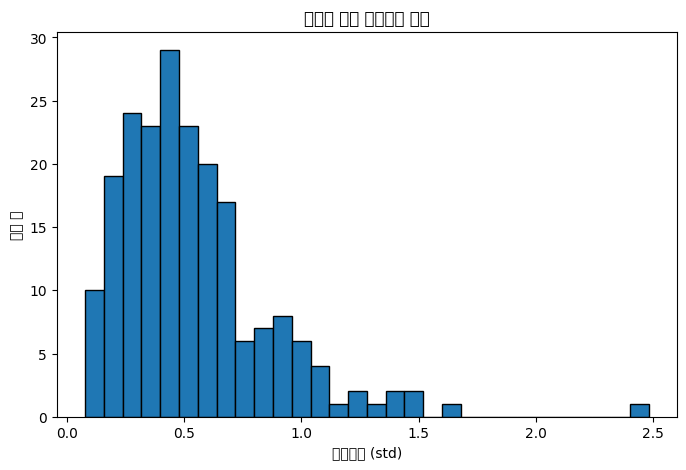

In [8]:
# 히스토그램으로 나타내기
plt.figure(figsize=(8,5))
plt.hist(std_cb, bins=30, edgecolor='k')
plt.xlabel("불확실성 (std)")
plt.ylabel("샘플 수")
plt.title("테스트 세트 불확실성 분포")
plt.show()


In [9]:
# 상대 불확실성 계산
# 10% 이하이면 대체로 모델이 예측값에 자신있다고 판단
rel_unc = std_cb / mean_cb
print(f"평균 상대 불확실성 : {np.mean(rel_unc)*100:.1f}%")
print(f"중앙값 상대 불확실성 : {np.median(rel_unc)*100:.1f}%")
print(f"최댓값 상대 불확실성 : {rel_unc.max()*100:.1f}%")

평균 상대 불확실성 : 2.0%
중앙값 상대 불확실성 : 1.6%
최댓값 상대 불확실성 : 8.6%


C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49345 (\N{HANGUL SYLLABLE SANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\SAL\AppData\Roaming\Python\Python38\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


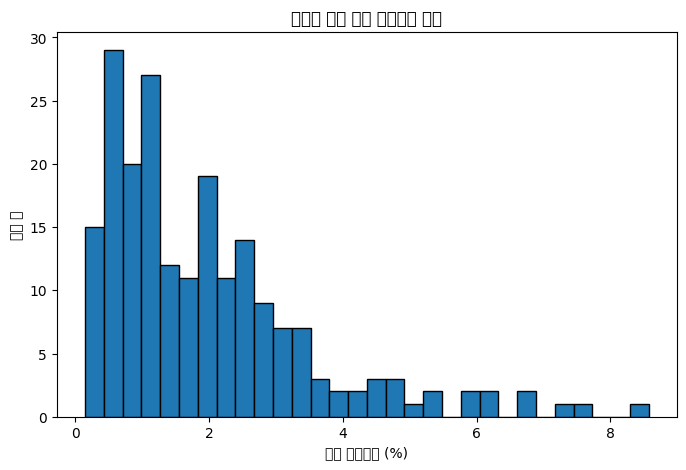

In [10]:
# 상대 불확실성 분포 히스토그램
plt.figure(figsize=(8,5))
plt.hist(rel_unc*100, bins=30, edgecolor='k')
plt.xlabel("상대 불확실성 (%)")
plt.ylabel("샘플 수")
plt.title("테스트 세트 상대 불확실성 분포")
plt.show()